In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from read_data import read_json

In [2]:
path = "../outputs/instances"

In [3]:
instances = os.listdir(path)
instances.sort(key=lambda x: int("".join(filter(str.isdigit, x))))
instances

['had12', 'rou15', 'esc16a', 'kra30a', 'ste36c', 'tai40b', 'sko81', 'lipa90b']

In [4]:
instances_data = {}

for instance in instances:
    instance_path = os.path.join(path, instance)
    instance_data = read_json(instance_path)
    instances_data[instance] = instance_data

instances_data.keys()

dict_keys(['had12', 'rou15', 'esc16a', 'kra30a', 'ste36c', 'tai40b', 'sko81', 'lipa90b'])

In [5]:
algos = [a for a, _ in instances_data[instances[0]].items()]
algos

['greedy_construction_heuristic',
 'random_search',
 'random_start_greedy_local_search',
 'random_start_steepest_local_search',
 'random_walk']

## Quality

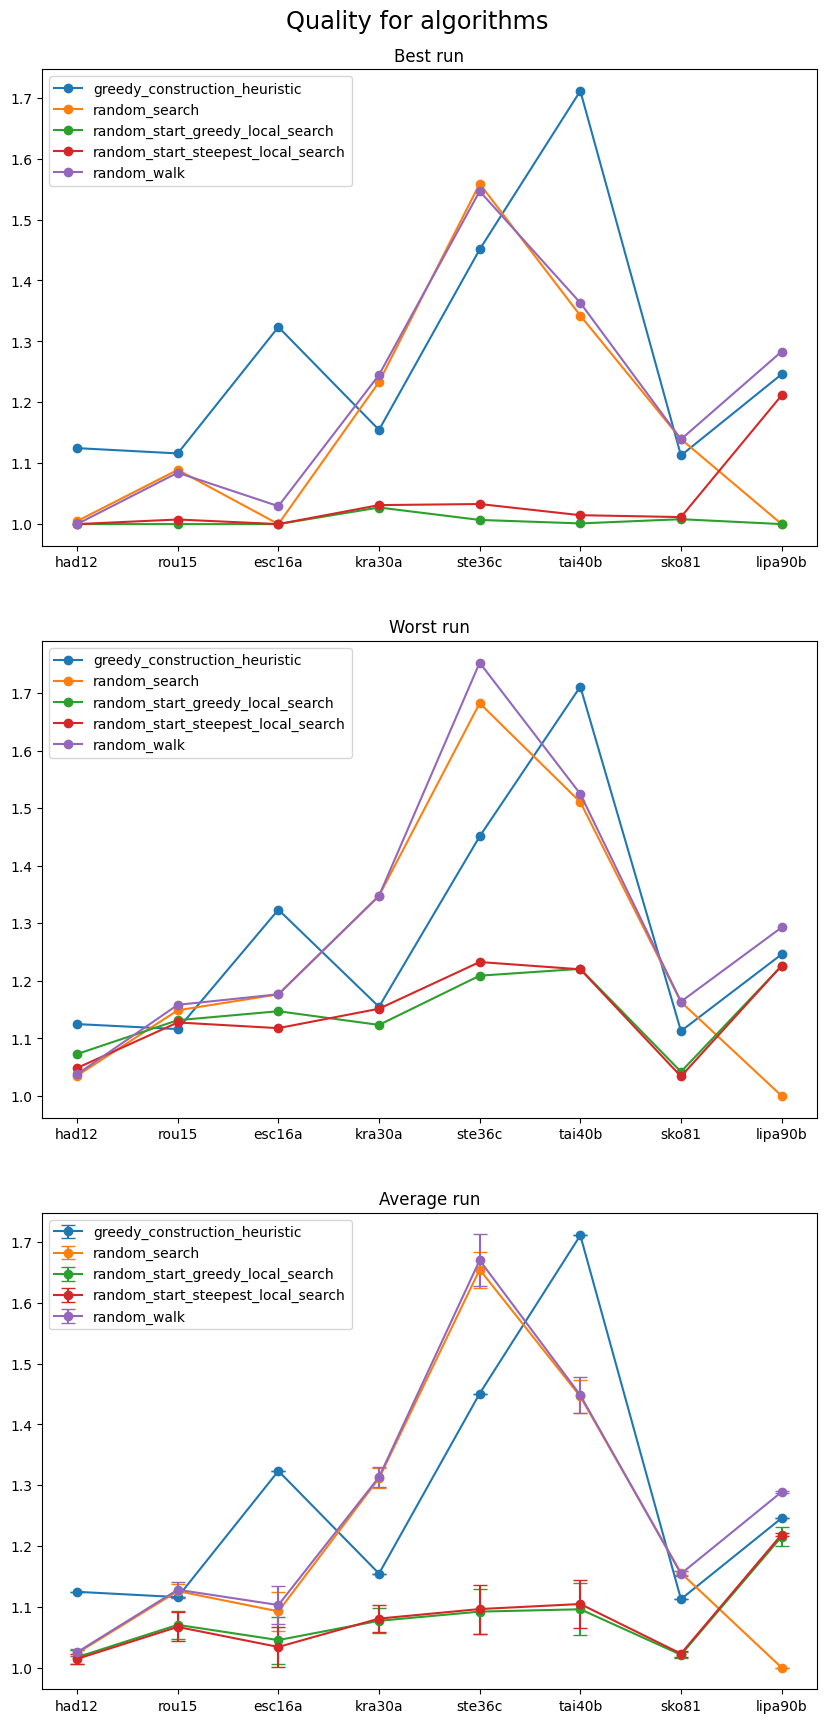

In [6]:
def plot_quality_per_instance(plots_n, subplot_index, get_final_score, title):
    ax = fig.add_subplot(plots_n, 1, subplot_index)

    for algo in algos:
        data = [get_final_score(instances_data[i][algo]) / instances_data[i][algo].optimum for i in instances]
        ax.plot(instances, data, label=algo, marker="o")
        ax.set_title(title)
        ax.legend()

fig = plt.figure( figsize=(10, 20) )
st = fig.suptitle("Quality for algorithms", fontsize="xx-large")

plot_quality_per_instance(3, 1, lambda x: x.best_run.final_score, "Best run")

plot_quality_per_instance(3, 2, lambda x: x.worst_run.final_score, "Worst run")

ax = fig.add_subplot(3, 1, 3)

for algo in algos:
    dirty_data = [[r.final_score / instances_data[i][algo].optimum for r in instances_data[i][algo].runs] for i in instances]
    data = [np.mean(dd) for dd in dirty_data]
    std = [np.std(dd) for dd in dirty_data]
    ax.errorbar(instances, data, yerr=std, label=algo, marker="o", capsize=5)
    ax.set_title("Average run")
    ax.legend()

st.set_y(0.95)
fig.subplots_adjust(top=0.92)

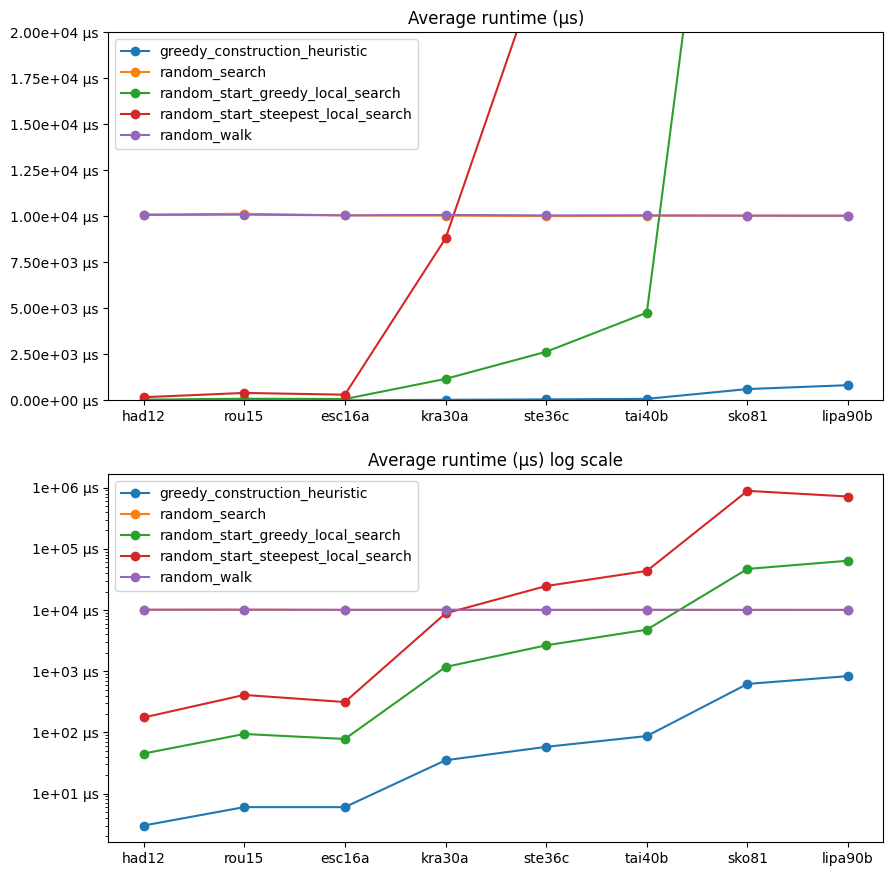

In [7]:
fig = plt.figure(figsize=(10, 10))

ax_norm = fig.add_subplot(2, 1, 1)
ax_log = fig.add_subplot(2, 1, 2)

for algo in algos:
    data = [instances_data[i][algo].avg_runtime for i in instances]
    ax_norm.plot(instances, data, label=algo, marker="o")
    ax_norm.set_title("Average runtime (μs)")
    ax_norm.legend()
    ax_norm.set_ylim(0, 20000)
    ax_norm.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2e μs"))


    ax_log.plot(instances, data, label=algo, marker="o")
    ax_log.set_title("Average runtime (μs) log scale")
    ax_log.set_yscale("log")
    ax_log.legend()
    ax_log.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.0e μs"))


fig.subplots_adjust(top=0.92)

## Effciency of algoirthm

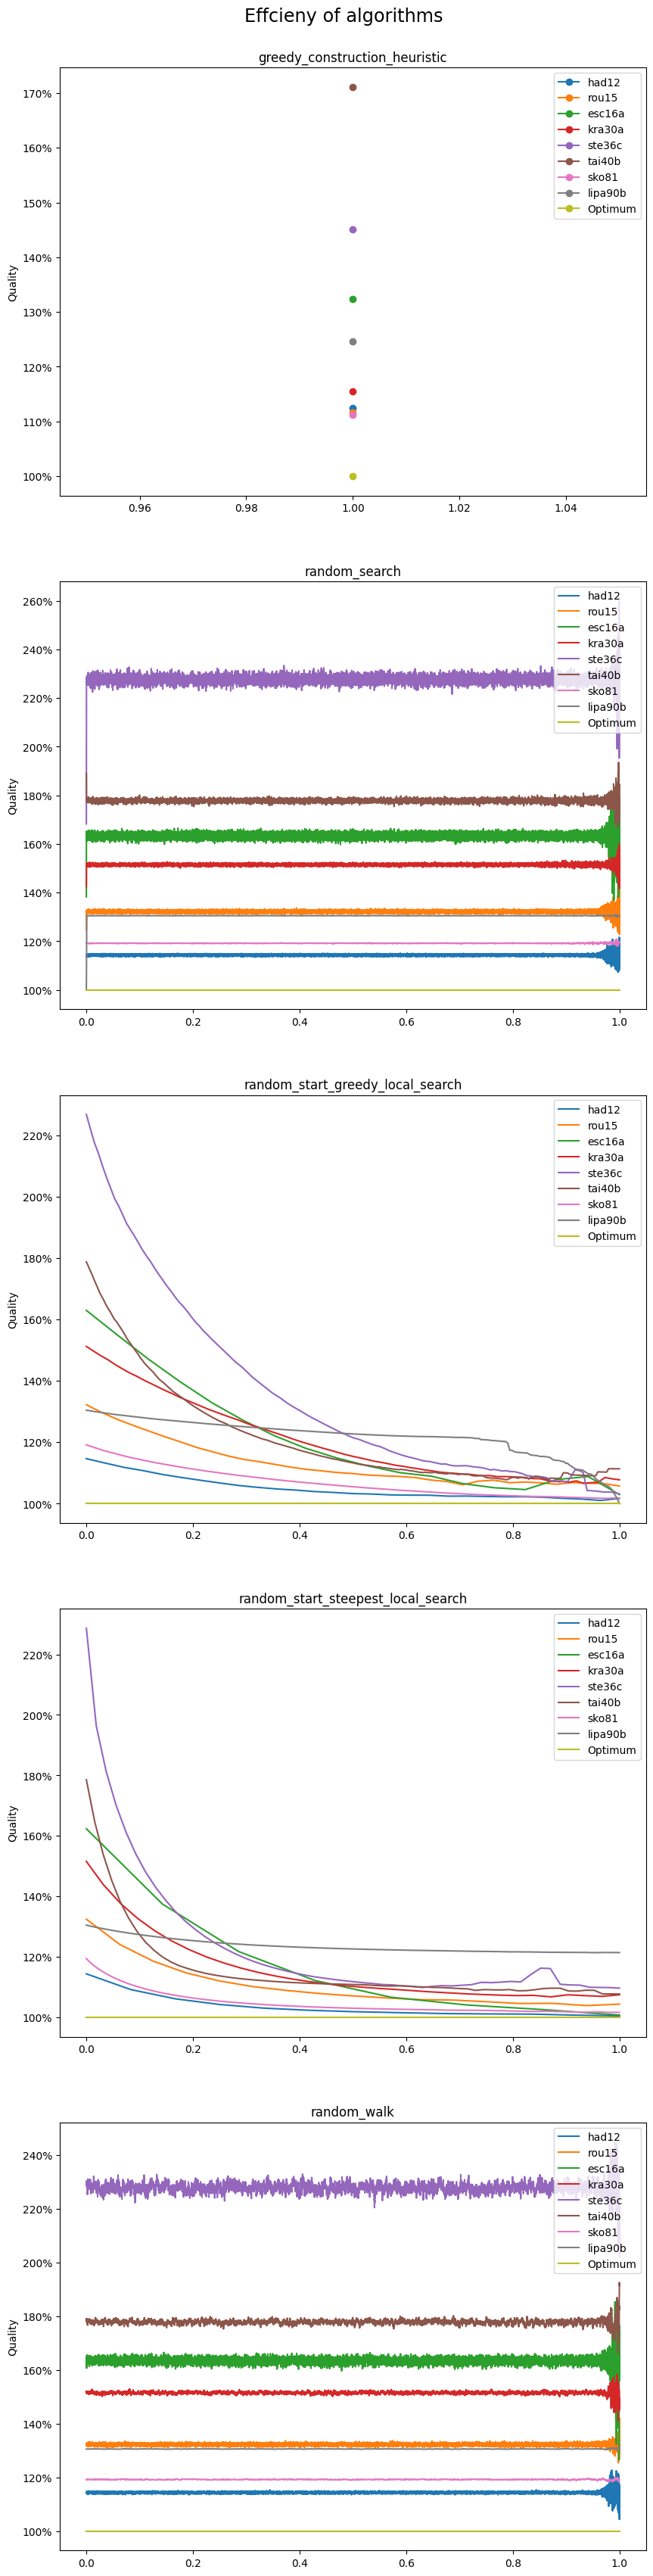

In [8]:
fig = plt.figure( figsize=(10, 40) )
st = fig.suptitle("Effcieny of algorithms", fontsize="xx-large")

algos_count = len(algos)

for i, algo in enumerate(algos):
    ax = fig.add_subplot(algos_count, 1, i + 1)
    do_the_line = False

    for instance in instances:

        algo_data = instances_data[instance][algo]

        y = []

        for step in range(max([r.iterations for r in algo_data.runs])):
            step_scores = [r.scores[step] for r in algo_data.runs if r.iterations > step]
            y.append(np.mean(step_scores) / algo_data.optimum)

        y = np.array(y) * 100

        if len(y) > 1:
            x = np.linspace(0, 1, len(y))    
            ax.plot(x, y, label=instance)
            do_the_line = True
        else:
            ax.plot([1], y, label=instance, marker="o")

    
    if do_the_line:
        ax.plot([0, 1], [100, 100], label="Optimum")
    else:
        ax.plot([1], [100], label="Optimum", marker="o")
        
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}%"))
    ax.set_title(algo)
    ax.legend()
    ax.set_ylabel("Quality")

st.set_y(0.95)
fig.subplots_adjust(top=0.93)

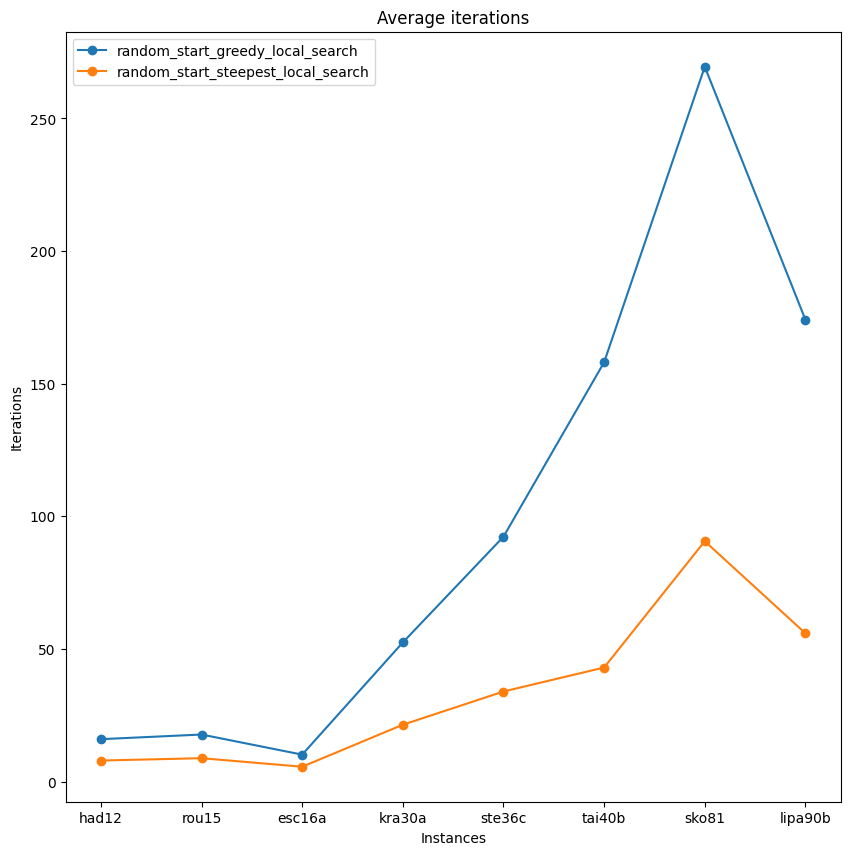

In [9]:
iterations = []
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1)

for algo in algos:
    
    if "local_search" not in algo: continue
    
    data = [np.mean([r.iterations for r in instances_data[i][algo].runs]) for i in instances]
    ax.plot(instances, data, label=algo, marker="o")
    ax.set_title("Average iterations")
    ax.set_ylabel("Iterations")
    ax.set_xlabel("Instances")
    ax.legend()
    

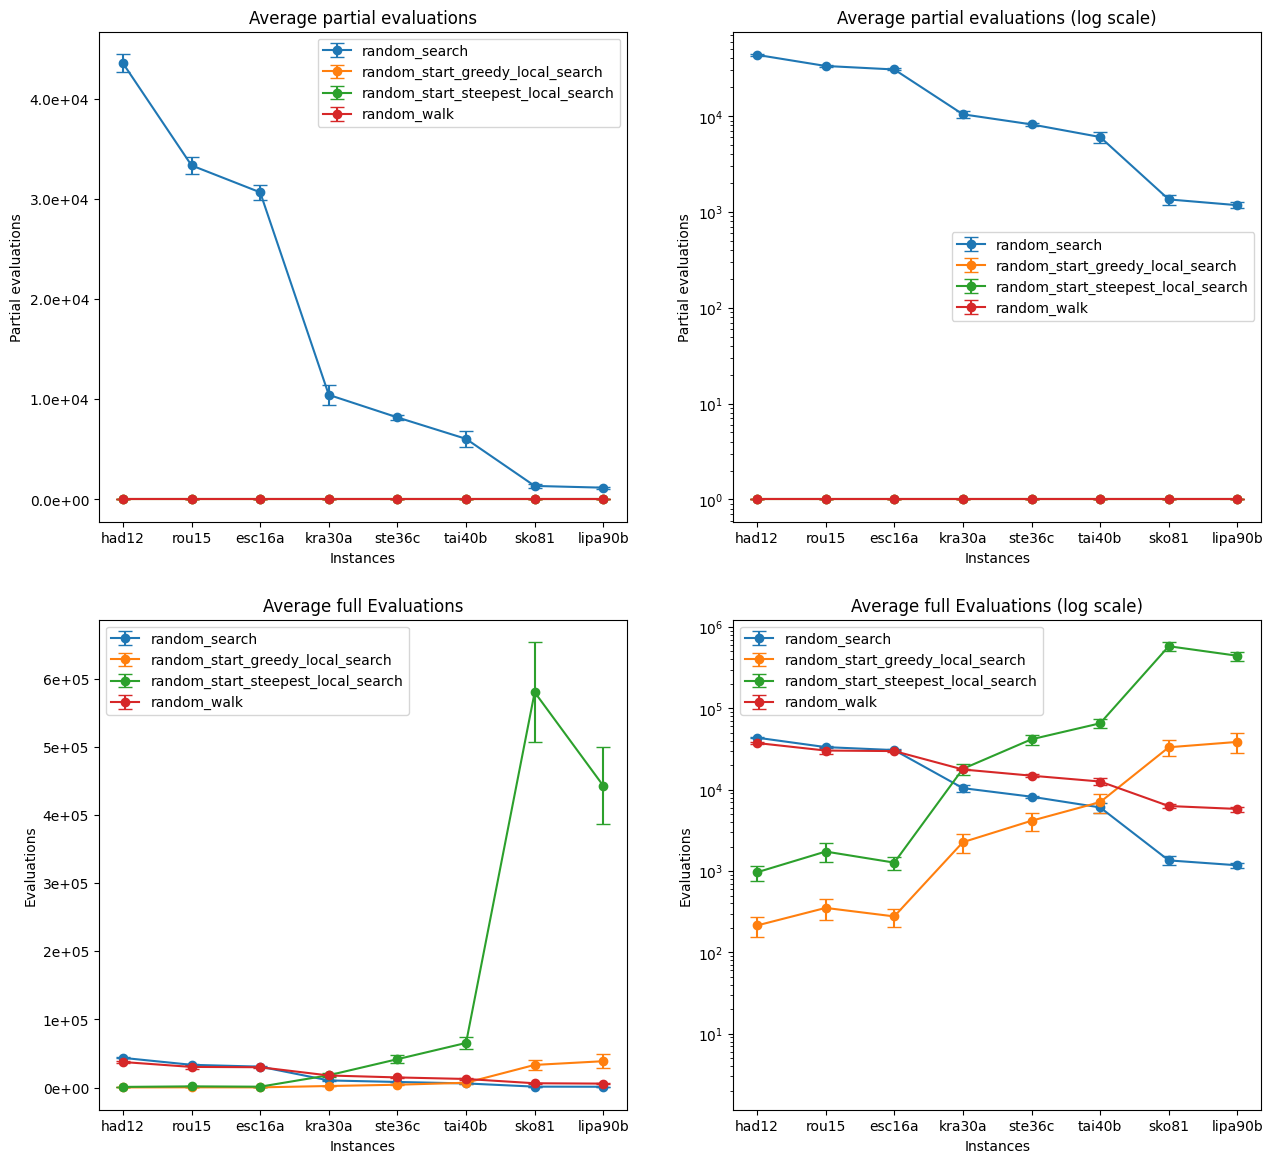

In [10]:
iterations = []
fig = plt.figure(figsize=(15, 14))

ax_partial = fig.add_subplot(2, 2, 1)
ax_partial_l = fig.add_subplot(2, 2, 2)
ax_full = fig.add_subplot(2, 2, 3)
ax_full_l = fig.add_subplot(2, 2, 4)


for algo in algos:
    
    if "heuristic" in algo: continue
    
    dirty_data_partial = [[r.evaluations - r.partial_evaluations for r in instances_data[i][algo].runs] for i in instances]
    dirty_data_full = [[r.evaluations for r in instances_data[i][algo].runs] for i in instances]

    data_partial = [np.mean(dd) for dd in dirty_data_partial]
    data_full = [np.mean(dd) for dd in dirty_data_full]

    std_partial = [np.std(dd) for dd in dirty_data_partial]
    std_full = [np.std(dd) for dd in dirty_data_full]

    ax_partial.errorbar(instances, data_partial, yerr=std_partial, capsize=5, marker="o", label=algo)
    ax_partial.set_title("Average partial evaluations")
    ax_partial.set_ylabel("Partial evaluations")
    ax_partial.set_xlabel("Instances")
    ax_partial.legend()
    ax_partial.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1e"))

    ax_partial_l.errorbar(instances, data_partial, yerr=std_partial, capsize=5, marker="o", label=algo)
    ax_partial_l.set_title("Average partial evaluations (log scale)")
    ax_partial_l.set_ylabel("Partial evaluations")
    ax_partial_l.set_xlabel("Instances")
    ax_partial_l.set_yscale("log")
    ax_partial_l.legend()
    
    ax_full.errorbar(instances, data_full, yerr=std_full, capsize=5, marker="o", label=algo)
    ax_full.set_title("Average full Evaluations")
    ax_full.set_ylabel("Evaluations")
    ax_full.set_xlabel("Instances")
    ax_full.legend()
    ax_full.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.0e"))

    ax_full_l.errorbar(instances, data_full, yerr=std_full, capsize=5, marker="o", label=algo)
    ax_full_l.set_title("Average full Evaluations (log scale)")
    ax_full_l.set_ylabel("Evaluations")
    ax_full_l.set_xlabel("Instances")
    ax_full_l.set_yscale("log")
    ax_full_l.legend()
    

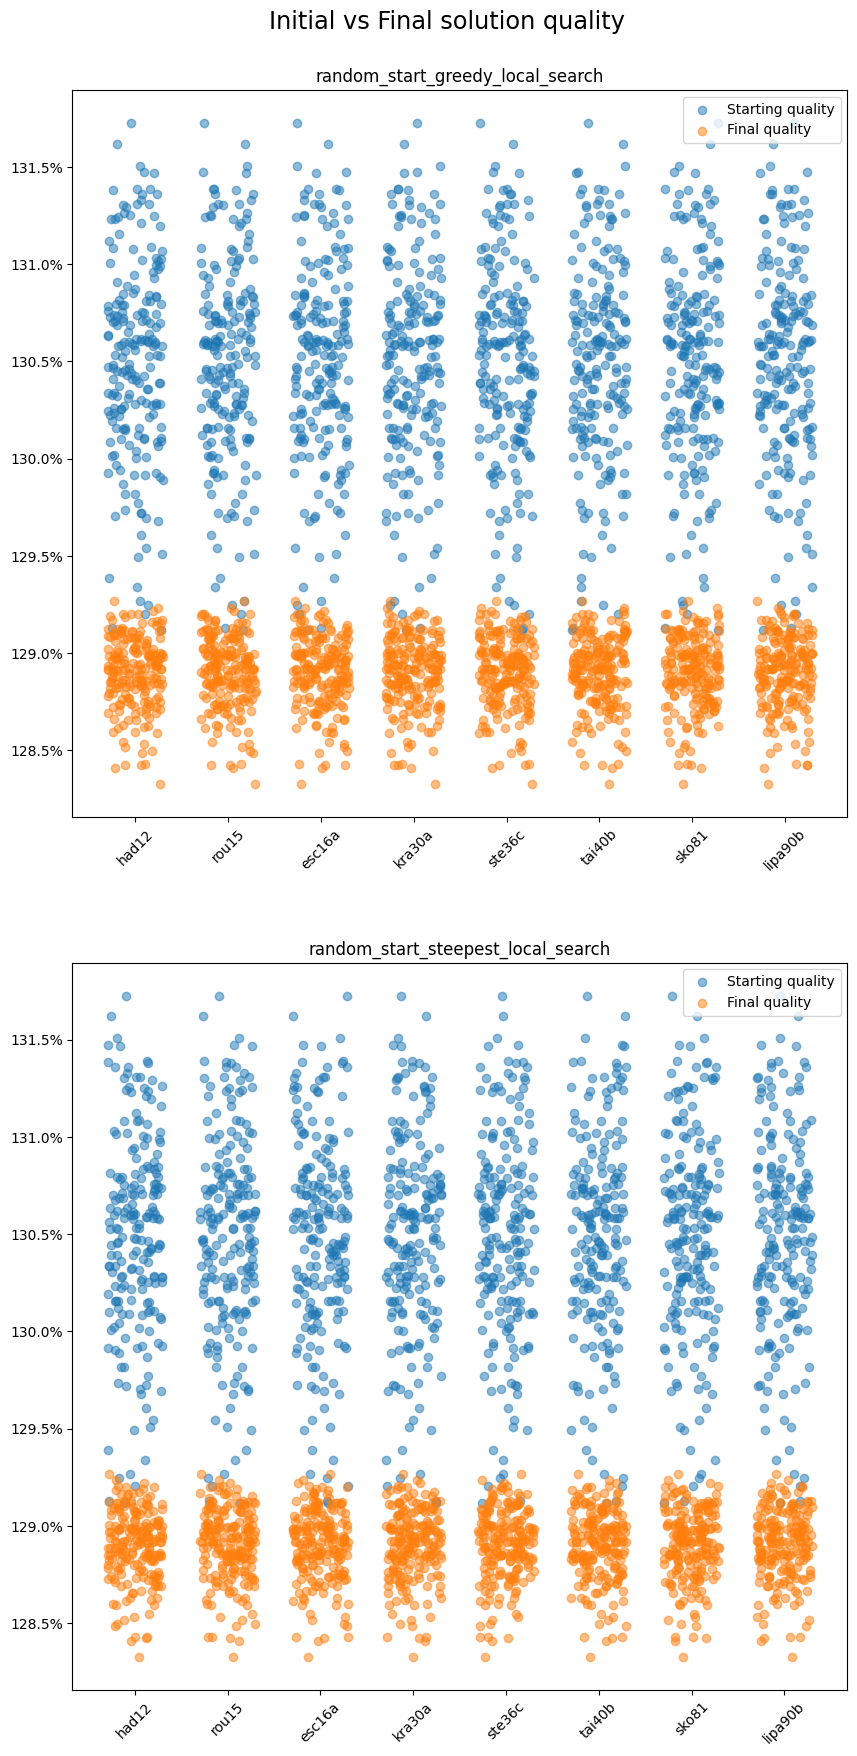

In [20]:
fig = plt.figure(figsize=(10, 20))
st = fig.suptitle("Initial vs Final solution quality", fontsize="xx-large")

# Create a mapping from instance names to numeric x-axis positions
instance_to_x = {inst: i for i, inst in enumerate(instances)}

for j, algo in enumerate(filter(lambda x: "local_search" in x, algos)):
    starting_quality = []
    final_quality = []
    x_jittered = []

    ax = fig.add_subplot(2, 1, j + 1)

    for instance in instances:
        instance_starting_quality = [r.scores[0] / algo_data.optimum * 100 for r in algo_data.runs]
        instance_final_quality = [r.final_score / algo_data.optimum * 100 for r in algo_data.runs]
        
        # Base x position for this instance
        base_x = instance_to_x[instance]
        jitter_strength = 0.3
        n = len(instance_starting_quality)
        
        # Jittered x positions
        jittered_x = base_x + np.random.uniform(-jitter_strength, jitter_strength, size=n)

        starting_quality.extend(instance_starting_quality)
        final_quality.extend(instance_final_quality)
        x_jittered.extend(jittered_x)

    ax.scatter(x_jittered, starting_quality, label="Starting quality", marker="o", alpha=0.5)
    ax.scatter(x_jittered, final_quality, label="Final quality", marker="o", alpha=0.5)
        
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}%"))

    # Set x-axis to categorical labels
    ax.set_xticks(list(instance_to_x.values()))
    ax.set_xticklabels(list(instance_to_x.keys()), rotation=45)
    ax.set_title(algo)
    ax.legend()

st.set_y(0.95)
fig.subplots_adjust(top=0.91)

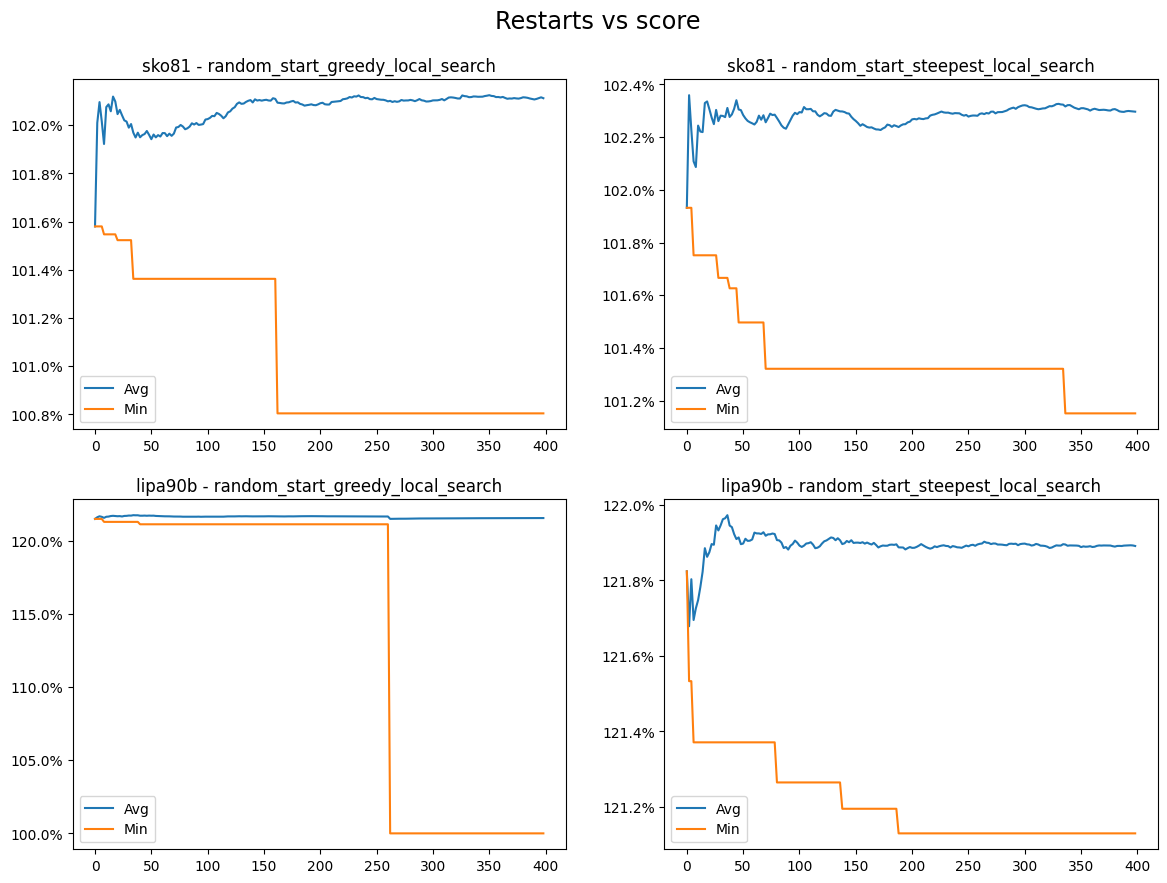

In [21]:
fig = plt.figure(figsize=(14, 10))
st = fig.suptitle("Restarts vs score", fontsize="xx-large")

for i, instance in enumerate(instances[-2:]):

    for j, algo in enumerate(filter(lambda x: "local_search" in x, algos)):
        ax = fig.add_subplot(2, 2, i * 2 + j + 1)
        
        y_min= []
        y_avg = []
        y_avg_buffer = []

        for r in instances_data[instance][algo].runs:
            score = r.final_score / instances_data[instance][algo].optimum * 100
            y_avg_buffer.append(score)
            y_avg.append(np.mean(y_avg_buffer))
            y_min.append(np.min(y_avg_buffer))

        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}%"))
        ax.set_title(f"{instance} - {algo}")

        x = np.arange(0, len(y_avg_buffer) * 2, 2)

        ax.plot(x, y_avg, label="Avg")
        ax.plot(x, y_min, label="Min")
        ax.legend()

st.set_y(0.95)
fig.subplots_adjust(top=0.88)

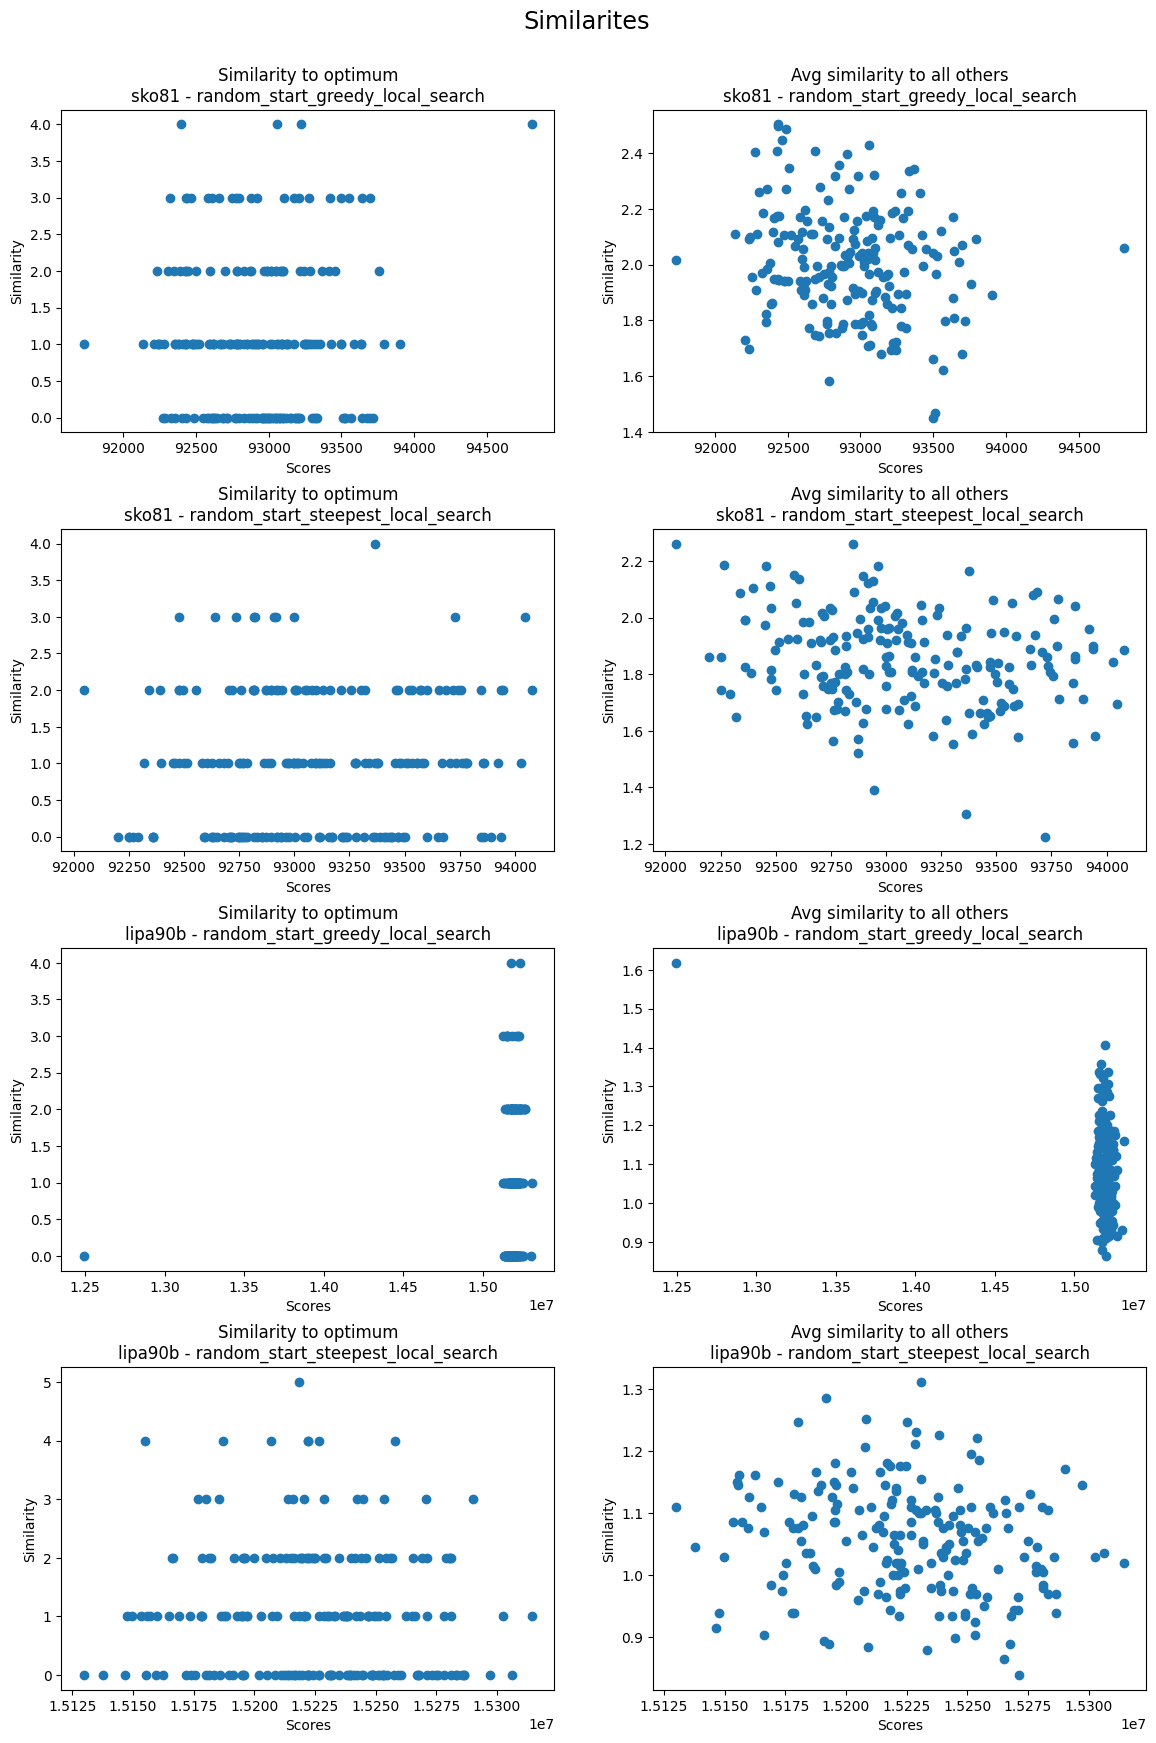

In [42]:
def set_ax_params(c_ax):
    c_ax.set_xlabel("Scores")
    c_ax.set_ylabel("Similarity")

fig = plt.figure(figsize=(14, 20))
st = fig.suptitle("Similarites", fontsize="xx-large")

ax_index = 1

for i, instance in enumerate(instances[-2:]):

    for j, algo in enumerate(filter(lambda x: "local_search" in x, algos)):

        ax = fig.add_subplot(4, 2, ax_index)
        ax_index += 1
        
        y = []
        x = []

        algo_data = instances_data[instance][algo]

        for bs in algo_data.similarities_best:
            x.append(bs[0])
            y.append(bs[1])

        ax.scatter(x, y)
        ax.set_title(f"Similarity to optimum\n{instance} - {algo}")
        set_ax_params(ax)

        ax = fig.add_subplot(4, 2, ax_index)
        ax_index += 1
        
        y = []
        x = []

        for bs in algo_data.similarities_avg:
            x.append(bs[0])
            y.append(bs[1])

        ax.scatter(x, y)
        ax.set_title(f"Avg similarity to all others\n{instance} - {algo}")
        set_ax_params(ax)

st.set_y(0.95)
fig.subplots_adjust(top=0.90, hspace=0.3)
